# Connect Four RL - Training with Live Metrics

Этот ноутбук позволяет:
- Настроить параметры обучения
- Запустить обучение DQN или Q-learning агента
- Визуализировать метрики в реальном времени


In [1]:
# Импорты
import sys
from pathlib import Path
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
import threading
from collections import defaultdict

# Добавляем путь к проекту
sys.path.insert(0, str(Path().resolve().parent))

from src.envs import Connect4Env
from src.agents import DQNAgent, QLearningAgent, RandomAgent, HeuristicAgent, SmartHeuristicAgent
from src.utils import MetricsLogger
from src.training.train_dqn import train_dqn
from src.training.train_qlearning import train_qlearning

print("Импорты успешно загружены!")


Импорты успешно загружены!


## Настройка параметров обучения

Выберите параметры для обучения:


In [2]:
# Параметры обучения
TRAINING_CONFIG = {
    # Тип модели
    "model_type": "dqn",  # "dqn" или "qlearning"
    
    # Параметры обучения
    "num_episodes": 50000,
    "learning_rate": 0.0001,
    "discount_factor": 0.99,
    "epsilon": 1.0,
    "epsilon_decay": 0.9995,  # Увеличено с 0.995 для более медленного decay
    # 0.995 -> минимум на эпизоде ~919 (слишком быстро)
    # 0.999 -> минимум на эпизоде ~4603
    # 0.9995 -> минимум на эпизоде ~9209 (рекомендуется для 50000 эпизодов)
    # 0.9999 -> минимум на эпизоде ~46050 (очень медленно)
    "epsilon_min": 0.01,
    
    # DQN специфичные параметры (игнорируются для Q-learning)
    "batch_size": 32,
    "replay_buffer_size": 20000,
    "target_update_freq": 100,
    "soft_update": True,
    "tau": 0.01,
    
    # Оппонент
    "opponent_type": "heuristic",  # "heuristic", "heuristic", или "smart_heuristic"
    
    # Оценка и сохранение
    "eval_freq": 100,
    "eval_episodes": 100,
    "save_freq": 1000,
    
    # Пути (используем абсолютные пути относительно корня проекта)
    "checkpoint_dir": str(Path().resolve().parent / "data" / "checkpoints"),
    "log_dir": str(Path().resolve().parent / "data" / "logs"),
    
    # Другие
    "device": None,  # None для auto-detect, или "cuda" или "cpu"
    "seed": 42,
    
    # Настройка наград
    "reward_win": 1.0,  # Награда за победу
    "reward_loss": -1.0,  # Награда за поражение
    "reward_draw": 0.0,  # Награда за ничью
    "reward_three_in_row": 0.01,  # Награда за 3 в ряд (промежуточная награда)
    "reward_opponent_three_in_row": -0.01,  # Штраф за вражеские 3 в ряд (промежуточный штраф)
    "reward_invalid_action": -0.1,  # Награда за неверный ход
}

# Параметры визуализации
PLOT_CONFIG = {
    "update_freq": 50,  # Обновлять графики каждые N эпизодов
    "metrics_to_plot": [
        "win_rate",
        "loss_rate",
        "episode_reward",
        "episode_length",
        "epsilon",
        "train_loss",
        "train_avg_q",
        "train_td_error",
    ],
}

print("Параметры настроены!")
print(f"Тип модели: {TRAINING_CONFIG['model_type']}")
print(f"Количество эпизодов: {TRAINING_CONFIG['num_episodes']}")
print(f"Оппонент: {TRAINING_CONFIG['opponent_type']}")
print(f"\nНаграды:")
print(f"  Победа: {TRAINING_CONFIG['reward_win']}")
print(f"  Поражение: {TRAINING_CONFIG['reward_loss']}")
print(f"  Ничья: {TRAINING_CONFIG['reward_draw']}")
print(f"  3 в ряд: {TRAINING_CONFIG['reward_three_in_row']}")
print(f"  Вражеские 3 в ряд (штраф): {TRAINING_CONFIG['reward_opponent_three_in_row']}")
print(f"  Неверный ход: {TRAINING_CONFIG['reward_invalid_action']}")


Параметры настроены!
Тип модели: dqn
Количество эпизодов: 50000
Оппонент: heuristic

Награды:
  Победа: 1.0
  Поражение: -1.0
  Ничья: 0.0
  3 в ряд: 0.01
  Вражеские 3 в ряд (штраф): -0.01
  Неверный ход: -0.1


## Функции для визуализации метрик


In [7]:
def load_metrics_from_csv(log_dir: str, metrics_file: str = None) -> pd.DataFrame:
    """Загрузить метрики из CSV файла.
    
    Args:
        log_dir: Директория с логами
        metrics_file: Путь к конкретному файлу метрик (если None, берется последний по времени создания)
    """
    if metrics_file and Path(metrics_file).exists():
        # Используем указанный файл
        df = pd.read_csv(metrics_file)
        return df
    
    # Ищем последний файл по времени создания (не модификации!)
    csv_files = list(Path(log_dir).glob("metrics_*.csv"))
    if not csv_files:
        return pd.DataFrame()
    
    # Берем последний файл по времени создания (st_ctime), а не модификации
    # Это более надежно, так как файл создается один раз при запуске обучения
    latest_file = max(csv_files, key=lambda x: x.stat().st_ctime)
    df = pd.read_csv(latest_file)
    return df

def plot_metrics(df: pd.DataFrame, metrics_to_plot: list, figsize=(15, 10)):
    """Построить графики метрик."""
    if df.empty:
        print("Нет данных для построения графиков")
        return
    
    n_metrics = len(metrics_to_plot)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        if metric not in df.columns:
            continue
        
        ax = axes[i]
        ax.plot(df['step'], df[metric], label=metric, linewidth=2)
        ax.set_xlabel('Episode')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} over time')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Добавляем последнее значение
        if len(df) > 0:
            last_val = df[metric].iloc[-1]
            ax.axhline(y=last_val, color='r', linestyle='--', alpha=0.5)
            ax.text(len(df), last_val, f'{last_val:.3f}', 
                   verticalalignment='bottom', fontsize=9)
    
    # Скрываем лишние subplots
    for i in range(n_metrics, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_win_rate_comparison(df: pd.DataFrame):
    """Построить график сравнения win/draw/loss rates."""
    if df.empty or 'win_rate' not in df.columns:
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if 'win_rate' in df.columns:
        ax.plot(df['step'], df['win_rate'], label='Win Rate', color='green', linewidth=2)
    if 'draw_rate' in df.columns:
        ax.plot(df['step'], df['draw_rate'], label='Draw Rate', color='gray', linewidth=2)
    if 'loss_rate' in df.columns:
        ax.plot(df['step'], df['loss_rate'], label='Loss Rate', color='red', linewidth=2)
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Rate')
    ax.set_title('Win/Draw/Loss Rates over Time')
    ax.set_ylim([0, 1])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Функции визуализации готовы!")


Функции визуализации готовы!


## Запуск обучения с визуализацией

Запустите обучение. Графики будут обновляться автоматически.


In [ ]:
# Создаем директории
os.makedirs(TRAINING_CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(TRAINING_CONFIG['log_dir'], exist_ok=True)

# Опционально: очистить старые логи перед новым обучением
# Раскомментируйте следующую строку, если хотите очищать логи перед каждым запуском
# import shutil
# if os.path.exists(TRAINING_CONFIG['log_dir']):
#     shutil.rmtree(TRAINING_CONFIG['log_dir'])
#     os.makedirs(TRAINING_CONFIG['log_dir'], exist_ok=True)

# Запускаем обучение в отдельном потоке
training_complete = threading.Event()
stop_training_flag = threading.Event()  # Флаг для остановки обучения
training_thread = None
current_metrics_file = None  # Путь к текущему файлу метрик

def run_training():
    """Запустить обучение в отдельном потоке."""
    global current_metrics_file
    try:
        # Определяем путь к файлу метрик, который будет создан
        # MetricsLogger создает файл с timestamp при инициализации
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        current_metrics_file = os.path.join(TRAINING_CONFIG['log_dir'], f"metrics_{timestamp}.csv")
        if TRAINING_CONFIG['model_type'] == 'dqn':
            train_dqn(
                num_episodes=TRAINING_CONFIG['num_episodes'],
                learning_rate=TRAINING_CONFIG['learning_rate'],
                discount_factor=TRAINING_CONFIG['discount_factor'],
                epsilon=TRAINING_CONFIG['epsilon'],
                epsilon_decay=TRAINING_CONFIG['epsilon_decay'],
                epsilon_min=TRAINING_CONFIG['epsilon_min'],
                batch_size=TRAINING_CONFIG['batch_size'],
                replay_buffer_size=TRAINING_CONFIG['replay_buffer_size'],
                target_update_freq=TRAINING_CONFIG['target_update_freq'],
                soft_update=TRAINING_CONFIG['soft_update'],
                tau=TRAINING_CONFIG['tau'],
                opponent_type=TRAINING_CONFIG['opponent_type'],
                eval_freq=TRAINING_CONFIG['eval_freq'],
                eval_episodes=TRAINING_CONFIG['eval_episodes'],
                save_freq=TRAINING_CONFIG['save_freq'],
                checkpoint_dir=TRAINING_CONFIG['checkpoint_dir'],
                log_dir=TRAINING_CONFIG['log_dir'],
                device=TRAINING_CONFIG['device'],
                seed=TRAINING_CONFIG['seed'],
                stop_flag=stop_training_flag,
                reward_win=TRAINING_CONFIG['reward_win'],
                reward_loss=TRAINING_CONFIG['reward_loss'],
                reward_draw=TRAINING_CONFIG['reward_draw'],
                reward_three_in_row=TRAINING_CONFIG['reward_three_in_row'],
                reward_opponent_three_in_row=TRAINING_CONFIG['reward_opponent_three_in_row'],
                reward_invalid_action=TRAINING_CONFIG['reward_invalid_action'],
            )
        elif TRAINING_CONFIG['model_type'] == 'qlearning':
            train_qlearning(
                num_episodes=TRAINING_CONFIG['num_episodes'],
                learning_rate=TRAINING_CONFIG['learning_rate'],
                discount_factor=TRAINING_CONFIG['discount_factor'],
                epsilon=TRAINING_CONFIG['epsilon'],
                epsilon_decay=TRAINING_CONFIG['epsilon_decay'],
                epsilon_min=TRAINING_CONFIG['epsilon_min'],
                opponent_type=TRAINING_CONFIG['opponent_type'],
                eval_freq=TRAINING_CONFIG['eval_freq'],
                eval_episodes=TRAINING_CONFIG['eval_episodes'],
                save_freq=TRAINING_CONFIG['save_freq'],
                checkpoint_dir=TRAINING_CONFIG['checkpoint_dir'],
                log_dir=TRAINING_CONFIG['log_dir'],
                seed=TRAINING_CONFIG['seed'],
                stop_flag=stop_training_flag,
                reward_win=TRAINING_CONFIG['reward_win'],
                reward_loss=TRAINING_CONFIG['reward_loss'],
                reward_draw=TRAINING_CONFIG['reward_draw'],
                reward_three_in_row=TRAINING_CONFIG['reward_three_in_row'],
                reward_opponent_three_in_row=TRAINING_CONFIG['reward_opponent_three_in_row'],
                reward_invalid_action=TRAINING_CONFIG['reward_invalid_action'],
            )
    except Exception as e:
        print(f"Ошибка при обучении: {e}")
        import traceback
        traceback.print_exc()
    finally:
        training_complete.set()

# Запускаем обучение
print("Запуск обучения...")
training_thread = threading.Thread(target=run_training, daemon=True)
training_thread.start()

print("Обучение запущено в фоновом режиме!")
print("Используйте следующую ячейку для мониторинга прогресса.")


Запуск обучения...
Обучение запущено в фоновом режиме!
Используйте следующую ячейку для мониторинга прогресса.
Ошибка при обучении: name 'reward_opponent_three_in_row' is not defined


Traceback (most recent call last):
  File "/tmp/ipykernel_30921/607682976.py", line 28, in run_training
    train_dqn(
  File "/home/holidin/projects/RL/src/training/train_dqn.py", line 80, in train_dqn
    reward_opponent_three_in_row=reward_opponent_three_in_row,
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
NameError: name 'reward_opponent_three_in_row' is not defined


## Остановка обучения

**Используйте эту ячейку для остановки обучения, если оно запущено в фоновом режиме.**


In [ ]:
# Остановка обучения
if 'stop_training_flag' in globals() and stop_training_flag is not None:
    stop_training_flag.set()
    print("🛑 Сигнал остановки отправлен обучению!")
    print("Обучение остановится после завершения текущего эпизода.")
    print("Проверьте метрики через несколько секунд.")
else:
    print("⚠️  Обучение не запущено или переменные не инициализированы.")
    print("Если обучение все еще работает, попробуйте:")
    print("1. Перезапустить ядро ноутбука (Kernel -> Restart)")
    print("2. Или найти процесс Python и остановить его вручную:")
    print("   ps aux | grep train_dqn")
    print("   kill <PID>")


🛑 Сигнал остановки отправлен обучению!
Обучение остановится после завершения текущего эпизода.
Проверьте метрики через несколько секунд.


  Detailed metrics: Max Q: 0.1113 | Min Q: -1.0622 | Target Q: -0.1111 | Grad Norm (clipped): 0.4033 | Total train steps: 5425 | Step count: 5456

🛑 Обучение остановлено пользователем на эпизоде 751/50000
Checkpoint saved: /home/holidin/projects/RL/data/checkpoints/dqn_episode_751_stopped.pt

Training stopped. Final model saved: /home/holidin/projects/RL/data/checkpoints/dqn_final.pt


## Мониторинг обучения в реальном времени

Запустите эту ячейку для обновления графиков. Можно запускать многократно.


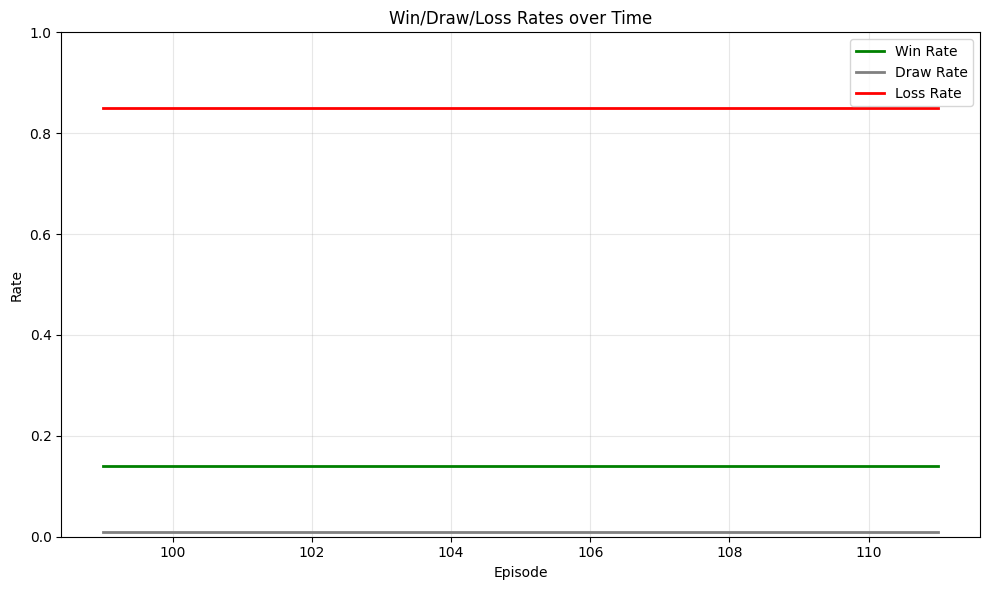

/tmp/ipykernel_16255/3227676984.py:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


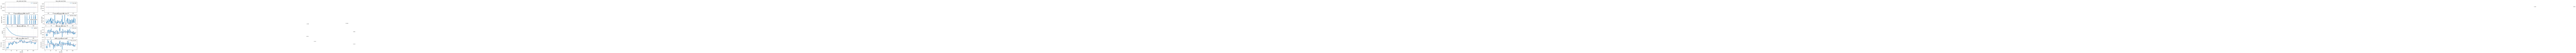

⏳ Обучение продолжается... (эпизод 111/5000)


  Detailed metrics: Max Q: 0.9289 | Min Q: -0.5095 | Target Q: 0.1902 | Grad Norm (clipped): 0.3557 | Total train steps: 31974 | Step count: 32005
Episode 400/5000 | Win: 19.00% | Draw: 0.00% | Loss: 81.00% | Epsilon: 0.0100 | Buffer: 4501/10000 (45.0%) | Train steps: 14 | Loss: 0.0375 | Avg Q: -0.2149 | TD Error: 0.1115 | Grad Norm: 0.1971
  Detailed metrics: Max Q: 0.1931 | Min Q: -0.6994 | Target Q: -0.1966 | Grad Norm (clipped): 0.1971 | Total train steps: 4470 | Step count: 4501
  Detailed metrics: Max Q: 0.6190 | Min Q: -0.4024 | Target Q: 0.1256 | Grad Norm (clipped): 0.2283 | Total train steps: 1508 | Step count: 1539
  Detailed metrics: Max Q: 0.3049 | Min Q: -0.5864 | Target Q: -0.1733 | Grad Norm (clipped): 0.1813 | Total train steps: 5086 | Step count: 5117
Episode 2700/5000 | Win: 17.00% | Draw: 1.00% | Loss: 82.00% | Epsilon: 0.0100 | Buffer: 10000/10000 (100.0%) | Train steps: 12 | Loss: 0.0587 | Avg Q: 0.1747 | TD Error: 0.1366 | Grad Norm: 0.3133
  Detailed metrics: Ma

In [21]:
# Загружаем метрики (используем текущий файл, если он определен)
if 'current_metrics_file' in globals() and current_metrics_file and Path(current_metrics_file).exists():
    df = load_metrics_from_csv(TRAINING_CONFIG['log_dir'], metrics_file=current_metrics_file)
    print(f"📊 Используется файл: {Path(current_metrics_file).name}")
else:
    df = load_metrics_from_csv(TRAINING_CONFIG['log_dir'])
    if not df.empty:
        # Показываем, какой файл был загружен
        csv_files = list(Path(TRAINING_CONFIG['log_dir']).glob("metrics_*.csv"))
        if csv_files:
            latest_file = max(csv_files, key=lambda x: x.stat().st_ctime)
            print(f"📊 Используется файл: {latest_file.name}")

if not df.empty:
    print(f"Загружено {len(df)} записей метрик")
    print(f"Последний эпизод: {df['step'].max()}")
    print(f"\nПоследние метрики:")
    print(df.tail(1)[['step'] + [m for m in PLOT_CONFIG['metrics_to_plot'] if m in df.columns]].to_string())
    print()
    
    # Строим графики
    clear_output(wait=True)
    
    # График win/draw/loss rates
    plot_win_rate_comparison(df)
    
    # Графики других метрик
    plot_metrics(df, PLOT_CONFIG['metrics_to_plot'])
    
    # Проверяем, завершено ли обучение
    if training_complete.is_set():
        print("✅ Обучение завершено!")
    else:
        print(f"⏳ Обучение продолжается... (эпизод {df['step'].max()}/{TRAINING_CONFIG['num_episodes']})")
else:
    print("⏳ Ожидание данных... Обучение только началось.")
    if training_complete.is_set():
        print("✅ Обучение завершено, но метрики еще не загружены.")


## Автоматическое обновление графиков (опционально)

Запустите эту ячейку для автоматического обновления графиков каждые N секунд.


Обновление #5 | Эпизод: 379/5000


KeyboardInterrupt: 

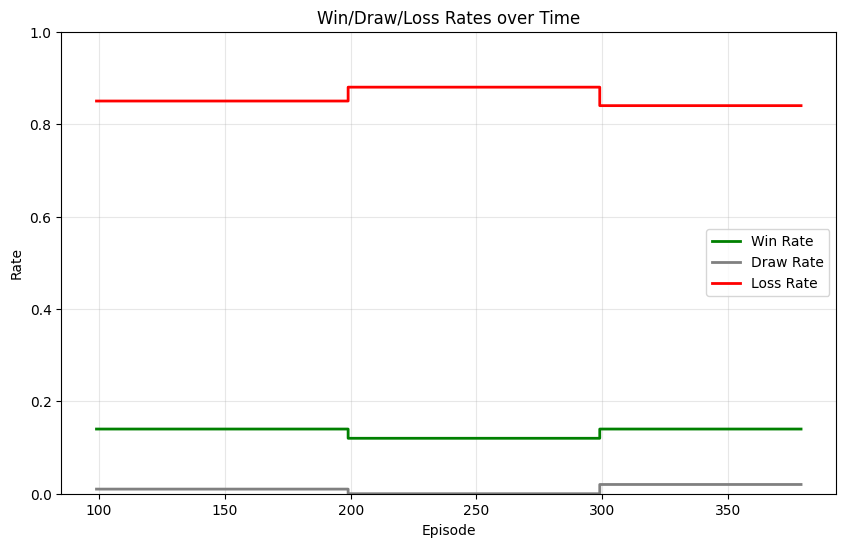

Episode 400/5000 | Win: 3.00% | Draw: 0.00% | Loss: 97.00% | Epsilon: 0.0100 | Buffer: 4267/10000 (42.7%) | Train steps: 9 | Loss: 0.0747 | Avg Q: 0.1772 | TD Error: 0.1445 | Grad Norm: 0.2780
  Detailed metrics: Max Q: 0.6982 | Min Q: -0.4611 | Target Q: 0.1983 | Grad Norm (clipped): 0.2780 | Total train steps: 4236 | Step count: 4267
  Detailed metrics: Max Q: 0.1683 | Min Q: -0.6823 | Target Q: -0.2797 | Grad Norm (clipped): 0.1802 | Total train steps: 7534 | Step count: 7565


In [22]:
# Автоматическое обновление графиков
import time
from IPython.display import clear_output

UPDATE_INTERVAL = 10  # Обновлять каждые N секунд
MAX_UPDATES = 1000  # Максимальное количество обновлений

print(f"Начинаю автоматическое обновление графиков каждые {UPDATE_INTERVAL} секунд...")
print("Нажмите Interrupt (Ctrl+C) чтобы остановить")

for update_count in range(MAX_UPDATES):
    # Загружаем метрики (используем текущий файл, если он определен)
    if 'current_metrics_file' in globals() and current_metrics_file and Path(current_metrics_file).exists():
        df = load_metrics_from_csv(TRAINING_CONFIG['log_dir'], metrics_file=current_metrics_file)
    else:
        df = load_metrics_from_csv(TRAINING_CONFIG['log_dir'])
    
    if not df.empty:
        clear_output(wait=True)
        
        print(f"Обновление #{update_count + 1} | Эпизод: {df['step'].max()}/{TRAINING_CONFIG['num_episodes']}")
        
        # График win/draw/loss rates
        plot_win_rate_comparison(df)
        
        # Графики других метрик
        plot_metrics(df, PLOT_CONFIG['metrics_to_plot'])
        
        # Проверяем, завершено ли обучение
        if training_complete.is_set():
            print("✅ Обучение завершено!")
            break
        
        # Показываем последние метрики
        if len(df) > 0:
            last_row = df.iloc[-1]
            print(f"\nПоследние метрики (эпизод {last_row['step']}):")
            for metric in PLOT_CONFIG['metrics_to_plot']:
                if metric in last_row:
                    print(f"  {metric}: {last_row[metric]:.4f}")
    else:
        print(f"⏳ Ожидание данных... ({update_count + 1}/{MAX_UPDATES})")
    
    # Ждем перед следующим обновлением
    time.sleep(UPDATE_INTERVAL)


## Финальная визуализация после обучения

Запустите эту ячейку после завершения обучения для финальных графиков.


In [ ]:
# Финальная загрузка и визуализация (используем текущий файл, если он определен)
if 'current_metrics_file' in globals() and current_metrics_file and Path(current_metrics_file).exists():
    df = load_metrics_from_csv(TRAINING_CONFIG['log_dir'], metrics_file=current_metrics_file)
else:
    df = load_metrics_from_csv(TRAINING_CONFIG['log_dir'])

if not df.empty:
    print("=" * 80)
    print("Финальные результаты обучения")
    print("=" * 80)
    print(f"Всего эпизодов: {len(df)}")
    print(f"Последний эпизод: {df['step'].max()}")
    print()
    
    # Показываем статистику
    if 'win_rate' in df.columns:
        print("Win Rate:")
        print(f"  Среднее: {df['win_rate'].mean():.2%}")
        print(f"  Последнее: {df['win_rate'].iloc[-1]:.2%}")
        print(f"  Максимум: {df['win_rate'].max():.2%}")
        print()
    
    if 'train_loss' in df.columns:
        print("Training Loss:")
        print(f"  Среднее: {df['train_loss'].mean():.4f}")
        print(f"  Последнее: {df['train_loss'].iloc[-1]:.4f}")
        print(f"  Минимум: {df['train_loss'].min():.4f}")
        print()
    
    # Строим финальные графики
    plot_win_rate_comparison(df)
    plot_metrics(df, PLOT_CONFIG['metrics_to_plot'])
    
    # Дополнительные графики
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Win rate
    if 'win_rate' in df.columns:
        axes[0, 0].plot(df['step'], df['win_rate'], label='Win Rate', color='green')
        axes[0, 0].set_title('Win Rate')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Rate')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim([0, 1])
    
    # Training loss
    if 'train_loss' in df.columns:
        axes[0, 1].plot(df['step'], df['train_loss'], label='Loss', color='red')
        axes[0, 1].set_title('Training Loss')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Episode reward
    if 'episode_reward' in df.columns:
        axes[1, 0].plot(df['step'], df['episode_reward'], label='Reward', color='blue')
        axes[1, 0].set_title('Episode Reward')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Reward')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Epsilon
    if 'epsilon' in df.columns:
        axes[1, 1].plot(df['step'], df['epsilon'], label='Epsilon', color='orange')
        axes[1, 1].set_title('Epsilon (Exploration Rate)')
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Epsilon')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Визуализация завершена!")
else:
    print("❌ Нет данных для визуализации. Убедитесь, что обучение было запущено.")


## Оценка обученной модели

Оцените обученную модель против разных оппонентов.


In [ ]:
# Выберите модель для оценки
MODEL_PATH = "data/checkpoints/dqn_final.pt"  # Измените на нужный путь
MODEL_TYPE = "dqn"  # "dqn" или "qlearning"

# Оценка против разных оппонентов
from src.training.eval_model import evaluate_model_against_opponents, print_results

results = evaluate_model_against_opponents(
    model_path=MODEL_PATH,
    model_type=MODEL_TYPE,
    opponents=["random", "heuristic", "smart_heuristic"],
    num_episodes=500,
    seed=42
)

print_results(results, MODEL_PATH)
